# Test basic framework functionality

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.insert(0, "../src")

In [3]:
import numpy as np
import pandas as pd
import xarray as xr

import matplotlib.pyplot as plt
import cartopy.crs as ccrs

import plot
import data_utils
import krige_tools
import fields
import cov_model
import cokrige

## Load and view data

In [4]:
# read 5-degree monthly data and subset to US for faster testing
time = "2019-07-01"
ds = xr.open_dataset("../data/exp_pro/OCO2_5deg_monthly.nc")

ds

<xarray.Dataset>
Dimensions:   (lat: 35, lon: 72, time: 75)
Coordinates:
  * lon       (lon) float64 -177.5 -172.5 -167.5 -162.5 ... 167.5 172.5 177.5
  * lat       (lat) float64 -87.5 -82.5 -77.5 -72.5 ... 67.5 72.5 77.5 82.5
  * time      (time) datetime64[ns] 2014-09-01 2014-10-01 ... 2020-11-01
Data variables:
    sif       (lon, lat, time) float32 ...
    sif_var   (lon, lat, time) float32 ...
    xco2      (lon, lat, time) float32 ...
    xco2_var  (lon, lat, time) float32 ...

## Setup fields and fit empirical kernels (params from variogram model)

In [5]:
ds_xco2 = ds[["xco2", "xco2_var"]]
ds_sif = ds[["sif", "sif_var"]]
Z = fields.MultiField(ds_xco2, ds_sif, "2019-07-01", timedelta=-2, center=True)

/home/jj829/sif-data-fusion/conda-env/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/home/jj829/sif-data-fusion/conda-env/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


In [6]:
"""
TODO: 
- look into how bin_edges are used in variogram fitting
- add option to set individual parameters manually
- don't spend too much time on the variogram approach
"""
bin_edges = np.arange(100)
k1 = cov_model.Matern()
k2 = cov_model.Matern()
model = cov_model.BivariateMatern(Z, k1, k2)._empirical_kernels(bin_edges)
predictor = cokrige.Cokrige(Z, model, fast_dist=True)

## Cokriging over XCO2 grid

In [7]:
pred_loc = krige_tools.land_grid(res=5, lat_lwr=-60, lat_upr=75)
pred, pred_err = predictor(pred_loc)

In [8]:
ds_pred = data_utils.to_xarray(pred_loc, pred=pred, pred_err=pred_err)
ds_pred

<xarray.Dataset>
Dimensions:   (lat: 27, lon: 72)
Coordinates:
  * lon       (lon) float64 -177.5 -172.5 -167.5 -162.5 ... 167.5 172.5 177.5
  * lat       (lat) float64 -57.5 -52.5 -47.5 -42.5 ... 57.5 62.5 67.5 72.5
Data variables:
    pred      (lon, lat) float64 nan nan nan nan nan ... nan 402.4 401.4 403.6
    pred_err  (lon, lat) float64 nan nan nan nan nan ... nan 0.7308 0.7522 1.973

## Plot data and results in a grid

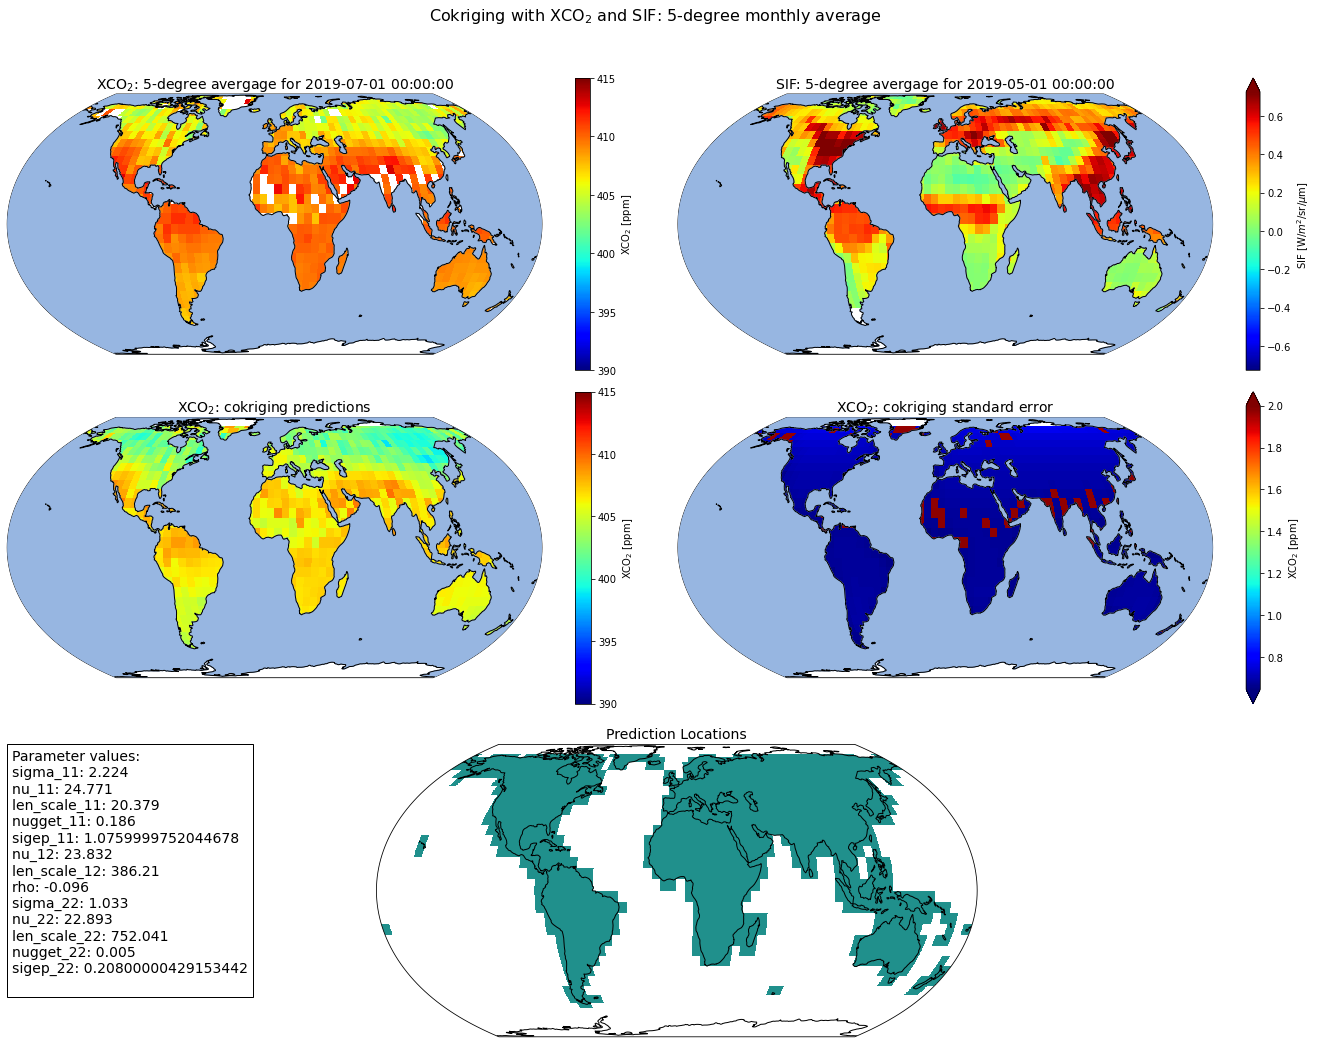

In [14]:
fig = plt.figure(figsize=(24, 18))
gs = fig.add_gridspec(100, 100)

fig.suptitle(
    "Cokriging with XCO$_2$ and SIF: 5-degree monthly average", 
    size=16, y=0.92
)

# Input data
ax1 = fig.add_subplot(gs[2:32, 0:50], projection=ccrs.EqualEarth())
ax2 = fig.add_subplot(gs[2:32, 50:], projection=ccrs.EqualEarth())
plot.plot_da(
    ds.xco2.sel(time=time),
    title=f"XCO$_2$: 5-degree avergage for {Z.field_1.timestamp}",
    ax=ax1,
    vmin=390,
    vmax=415,
    cbar_kwargs={"label": "XCO$_2$ [ppm]"}
)
plot.plot_da(
    ds.sif.sel(time=time),
    title=f"SIF: 5-degree avergage for {Z.field_2.timestamp}",
    ax=ax2,
    cbar_kwargs={"label": "SIF [W/$m^2$/sr/$\mu$m]"}
)

# Predictions and standard error
ax3 = fig.add_subplot(gs[34:66, 0:50], projection=ccrs.EqualEarth())
ax4 = fig.add_subplot(gs[34:66, 50:], projection=ccrs.EqualEarth())
plot.plot_da(
    ds_pred.pred,
    title="XCO$_2$: cokriging predictions",
    ax=ax3,
    vmin=390,
    vmax=415,
    cbar_kwargs={"label": "XCO$_2$ [ppm]"}
)
plot.plot_da(
    ds_pred.pred_err,
    title="XCO$_2$: cokriging standard error",
    ax=ax4,
    cbar_kwargs={"label": "XCO$_2$ [ppm]"}
)

# Prediction locations
ds_land = data_utils.to_xarray(pred_loc, land_mask=np.ones(pred_loc[:,1].size))
ax5 = fig.add_subplot(gs[70:, 25:75], projection=ccrs.EqualEarth())
ax5.set_global()
xr.plot.imshow(
    darray=ds_land.land_mask.T,
    transform=ccrs.PlateCarree(),
    ax=ax5,
    add_colorbar=False
)
ax5.coastlines(zorder=10)
ax5.set_title("Prediction Locations", size=14)

# Parameter values
param_values = [f"{key}: {np.round(value, 3)}\n" for key, value in model.get_params().items()]
ax6 = fig.add_subplot(gs[70:, :22])
padding = 5
ax6.annotate(
    text = "Parameter values:\n" + "".join(param_values), 
    fontsize = 14,
    xy=(0, 1), 
    xytext=(padding, -padding), 
    textcoords = "offset pixels",
    bbox=dict(facecolor="white", alpha=1, pad=padding),
    va="top",
    ha="left",
    )
ax6.axis("off")

fig.savefig("../plots/cokriging_prediction_demo_5degree_monthly.png");

**NOTES:**
- I'm not currently applying a scale factor to the data values. Once the mean has been removed, XCO2 is (roughly) on the order of (-10,10), and SIF is (roughly) on the order of (-0.5,0.5).
- I need to use absolute value of the diagonal elements when taking the square root to get prediction error; still some negative values in there.

**Questions:**
- If a model for the mean surface is used (i.e., modeled, removed, and added back), is the simple kriging predictor still the BLUP. Should we be using a variant of universal kriging?